In [17]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [18]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [19]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [20]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [21]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


/var/folders/q0/62b3m8qn6bvd3_bd3b18nw540000gn/T/ipykernel_71545/1526636886.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [22]:
# View all of the classes that automap found
Base.classes.keys()


['station', 'measurement']

In [23]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station



In [24]:
# Create our session (link) from Python to the DB
session = Session(engine)




# Exploratory Precipitation Analysis

In [49]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print("Most recent date:", recent_date[0])

Most recent date: 2017-08-23


<Figure size 1000x600 with 0 Axes>

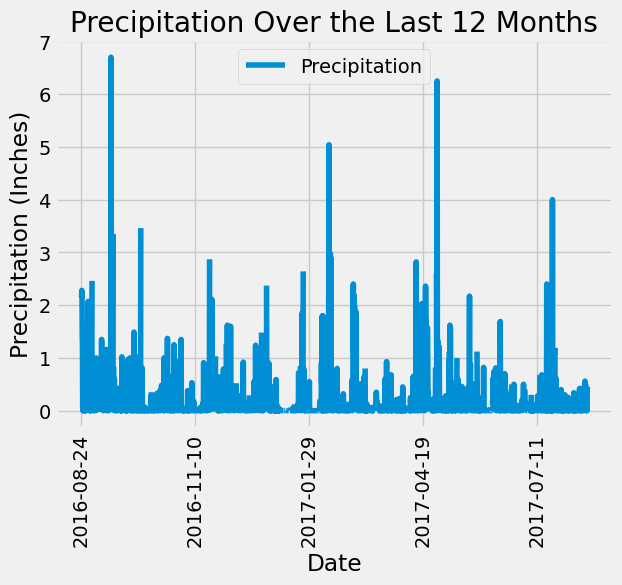

In [57]:
one_year_ago = dt.datetime.strptime(recent_date[0], '%Y-%m-%d') - dt.timedelta(days=365)

sel = [Measurement.date, Measurement.prcp]
query_result = session.query(*sel).filter(Measurement.date >= one_year_ago).all()

precipitation_df = pd.DataFrame(query_result, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date', inplace=True)

precipitation_df = precipitation_df.sort_index()



plt.figure(figsize=(10, 6))
precipitation_df.plot(rot=90)
plt.title("Precipitation Over the Last 12 Months")
plt.ylabel("Precipitation (Inches)")
plt.xlabel("Date")
plt.show()

In [64]:
summary_statistics = precipitation_df.describe()
print(summary_statistics)


       Precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [75]:
total_stations = session.query(Station).count()
print("Total number of stations:", total_stations)

Total number of stations: 9


In [84]:
most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                              .group_by(Measurement.station)\
                              .order_by(func.count(Measurement.station).desc())\
                              .all()
for station, count in most_active_stations:
    print("Station:", station, "Count:", count)

Station: USC00519281 Count: 2772
Station: USC00519397 Count: 2724
Station: USC00513117 Count: 2709
Station: USC00519523 Count: 2669
Station: USC00516128 Count: 2612
Station: USC00514830 Count: 2202
Station: USC00511918 Count: 1979
Station: USC00517948 Count: 1372
Station: USC00518838 Count: 511


In [88]:
most_active_station_id = most_active_stations[0][0]

sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

temperatures = session.query(*sel).filter(Measurement.station == most_active_station_id).all()
lowest_temp, highest_temp, average_temp = temperatures[0]

print(f"Most Active Station ID: {most_active_station_id}")
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {average_temp:.2f}")

Most Active Station ID: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


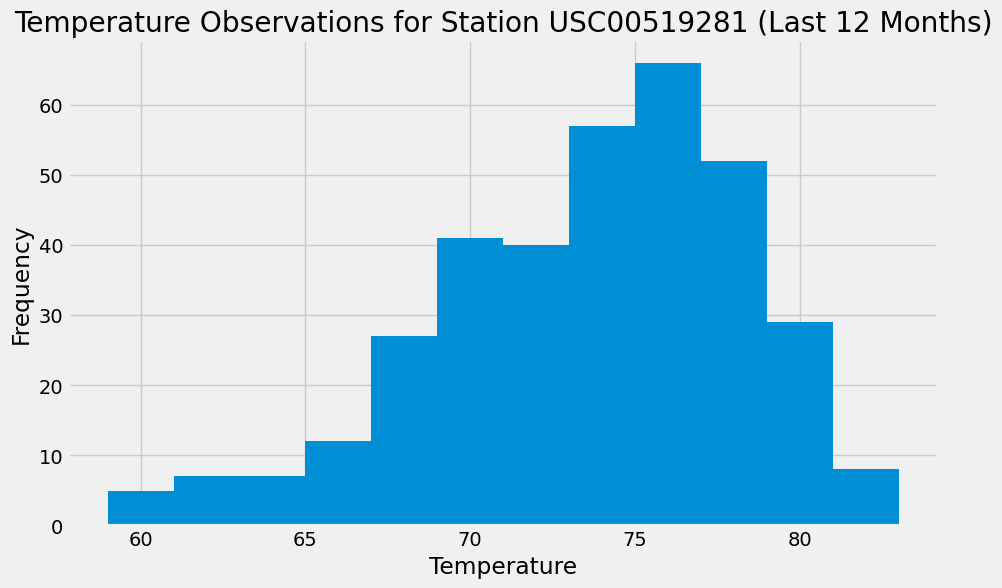

In [91]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_year_ago = dt.datetime.strptime(recent_date[0], '%Y-%m-%d') - dt.timedelta(days=365)
most_active_station_id = most_active_stations[0][0]

temperature_data = session.query(Measurement.tobs)\
                          .filter(Measurement.station == most_active_station_id)\
                          .filter(Measurement.date >= one_year_ago).all()
temperatures = [temp[0] for temp in temperature_data]

plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12)
plt.title(f"Temperature Observations for Station {most_active_station_id} (Last 12 Months)")
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()


# Close Session

In [92]:
# Close Session
session.close()